In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs

**Reproduction of Franco, Pedro, et al. "The use of 2D fingerprint methods to support the assessment of structural similarity in orphan drug legislation." Journal of cheminformatics 6 (2014): 1-10.**

In [2]:
data = pd.read_csv('../../data/raw/experts.csv')
data

,Pairs,SMILES - Molecule A,SMILES - Molecule B,YES %
0,1a,CCN(CC)CC(=O)NC1=C(C)C=CC=C1C,CCCN1CCCC[C@H]1C(=O)NC1=C(C)C=CC=C1C,46.88
1,2a,CC1=C(CCN2CCC(CC2)C2=NOC3=C2C=CC(F)=C3)C(=O)N2...,CC1=C(CCN2CCC(CC2)C2=NOC3=C2C=CC(F)=C3)C(=O)N2...,93.75
2,3a,COC1=CC=CC=C1OCC(O)CO,COC(=O)CCC1=CC=C(OCC(O)CNC(C)C)C=C1,14.06
3,4a,CCOC1=CC=CC=C1OCCN[C@H](C)CC1=CC(=C(OC)C=C1)S(...,CC(C)C(=O)NC1=CC(=C(C=C1)[N+]([O-])=O)C(F)(F)F,3.13
4,5a,C[C@H](N)CC1=CC=CC=C1,CC(C)(N)CC1=CC=CC=C1,88.28
...,...,...,...,...
95,96a,CCC(=O)O[C@@]1([C@@H](C)C[C@H]2[C@@H]3CCC4=CC(...,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)[C@H]2CC[C@@...,34.13
96,97a,C[C@H](N)[C@H](O)C1=CC(O)=C(O)C=C1,C[C@@H](N)[C@@H](O)C1=CC=CC=C1,74.80
97,98a,CCOC(=O)C1(CCN(C)CC1)C1=CC=CC=C1,N[C@@H](CC1=CC=C(O)C=C1)C(O)=O,1.59
98,99a,CC1(C)O[C@@H]2C[C@H]3[C@@H]4C[C@H](F)C5=CC(=O)...,C[C@H]1C[C@H]2[C@@H]3CC[C@](O)(C(=O)CO)[C@@]3(...,67.72


In [17]:
y = data['YES %'] / 100

a_smiles = data['SMILES - Molecule A']
b_smiles = data['SMILES - Molecule B']

# Reproduce the Figure 3 with difference ECFP4 fingerprints

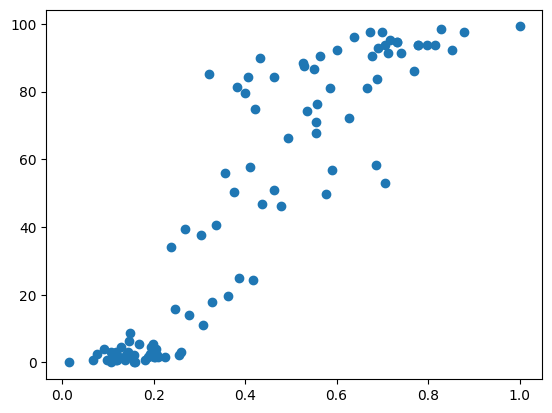

In [4]:
first_sim = []
for i in range(len(a_smiles)):
    a_mol = Chem.MolFromSmiles(a_smiles[i])
    b_mol = Chem.MolFromSmiles(b_smiles[i])

    a_fp = AllChem.GetMorganFingerprint(a_mol, radius=2)
    b_fp = AllChem.GetMorganFingerprint(b_mol, radius=2)
    # Calculate the tanimoto similarity between the query fingerprint and the current fingerprint
    first_sim.append(DataStructs.TanimotoSimilarity(a_fp, b_fp))

plt.scatter(first_sim, y)

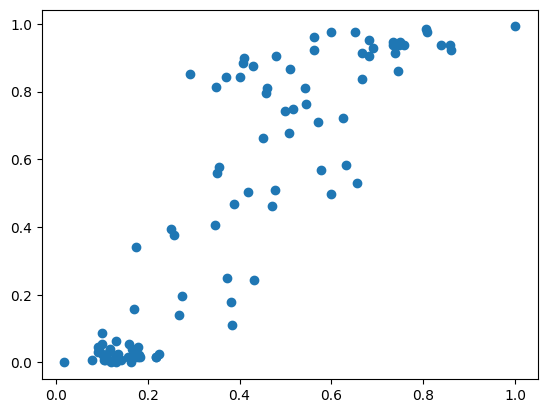

In [18]:
second_sim = []
for i in range(len(a_smiles)):
    a_mol = Chem.MolFromSmiles(a_smiles[i])
    b_mol = Chem.MolFromSmiles(b_smiles[i])

    a_fp = AllChem.GetMorganFingerprintAsBitVect(a_mol, 2, 1024)
    b_fp = AllChem.GetMorganFingerprintAsBitVect(b_mol, 2, 1024)
    # Calculate the tanimoto similarity between the query fingerprint and the current fingerprint
    second_sim.append(DataStructs.TanimotoSimilarity(a_fp, b_fp))

plt.scatter(second_sim, y)

# Fit sigmoid to them

In [19]:
from scipy.optimize import curve_fit

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

p0 = [max(y), np.median(first_sim),1,min(y)]
popt, pcov = curve_fit(sigmoid, first_sim, y,p0, method='dogbox')

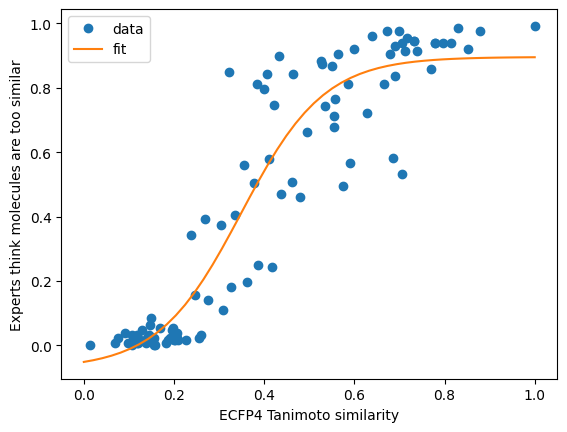

In [21]:
x = np.linspace(0, 1, 50)
sigmoid_y = sigmoid(x, *popt)

plt.plot(first_sim, y, 'o', label='data')
plt.plot(x,sigmoid_y, label='fit')
plt.legend(loc='best')
plt.xlabel('ECFP4 Tanimoto similarity')
plt.ylabel('Experts think molecules are too similar')
plt.show()

In [8]:
print('Percent of experts considering two molecules similar at 0.4 Tanimoto similarity:')
sigmoid(0.4, *popt)

Percent of experts considering two molecules similar at 0.4 Tanimoto similarity:


54.14317036472831

In [9]:
p0 = [max(y), np.median(second_sim),1,min(y)]
popt, pcov = curve_fit(sigmoid, second_sim, y,p0, method='dogbox')

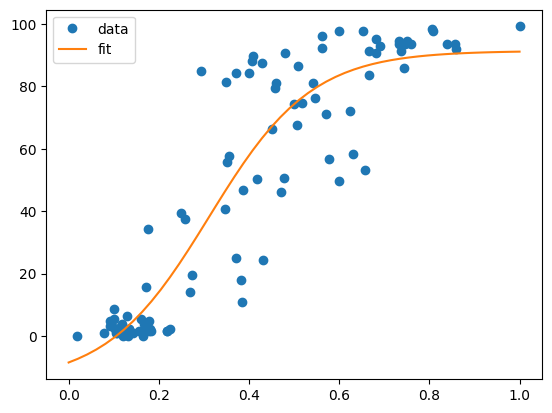

In [10]:
x = np.linspace(0, 1, 50)
sigmoid_y = sigmoid(x, *popt)

plt.plot(second_sim, y, 'o', label='data')
plt.plot(x,sigmoid_y, label='fit')
plt.legend(loc='best')
plt.show()

In [11]:
print('Percent of experts considering two molecules similar at 0.4 Tanimoto similarity:')
sigmoid(0.4, *popt)

Percent of experts considering two molecules similar at 0.4 Tanimoto similarity:


57.871018460848376

In [15]:

def inv_sigmoid(y, L, x0, k, b):
    x = x0 - (1 / k) * np.log((L / (y - b)) - 1)
    return x

inv_sigmoid(50, *popt)

0.362980867682671